In [17]:
!kaggle competitions download -c titanic -p "./dataset/"

100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 263kB/s]
100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 263kB/s]


In [16]:
!unzip ./dataset/titanic.zip -d ./dataset && rm ./dataset/titanic.zip

Archive:  ./dataset/titanic.zip
  inflating: ./dataset/gender_submission.csv  
  inflating: ./dataset/test.csv      
  inflating: ./dataset/train.csv     


In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_filepath = "./dataset/train.csv"
test_filepath = "./dataset/test.csv"
gender_submission_filepath = "./dataset/gender_submission.csv"
train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)
gender = pd.read_csv(gender_submission_filepath)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


결측치 보정

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


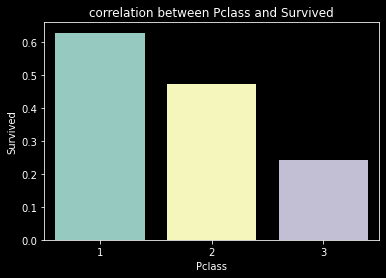

In [34]:
cor_Pclass_Survived = train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
print(cor_Pclass_Survived)
# plt.figure(figsize=(6,6))
plt.title("correlation between Pclass and Survived")
sns.barplot(x=cor_Pclass_Survived["Pclass"], y=cor_Pclass_Survived["Survived"]);
#groupby에 as_index를 False로 하면 Pclass를 Index로 사용하지 않음
#ascending : 오름차순

<AxesSubplot:title={'center':'correlation between sex and survived'}, xlabel='Sex', ylabel='Survived'>

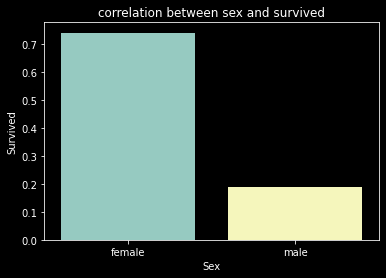

In [30]:
cor_Sex_Survived = train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by="Survived", ascending=False)
plt.title("correlation between sex and survived")
sns.barplot(x=cor_Sex_Survived["Sex"], y=cor_Sex_Survived["Survived"])

c:\Users\hyeonsu\anaconda3\envs\kaggleProject\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 72.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\hyeonsu\anaconda3\envs\kaggleProject\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 46.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Survived', ylabel='Fare'>

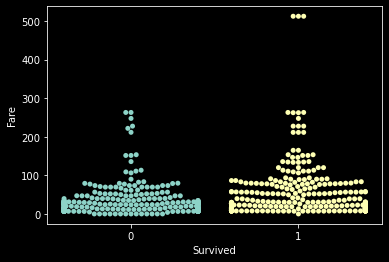

In [66]:
sns.swarmplot(x=train["Survived"], y=train["Fare"])

<AxesSubplot:title={'center':'correlation between SibSp and Survived'}, xlabel='SibSp', ylabel='Survived'>

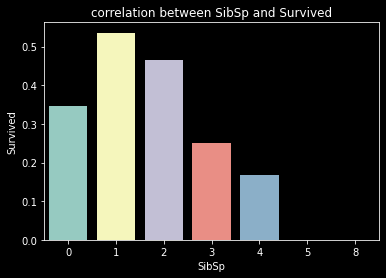

In [43]:
cor_SibSp_Survived = train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values("Survived", ascending=False)
plt.title("correlation between SibSp and Survived")
sns.barplot(x = cor_SibSp_Survived["SibSp"], y=cor_SibSp_Survived["Survived"])

<AxesSubplot:title={'center':'correlation between Parch and Survived'}, xlabel='Parch', ylabel='Survived'>

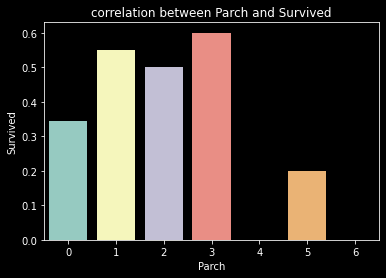

In [44]:
cor_Parch_Survived = train[["Parch","Survived"]].groupby(["Parch"], as_index=False).mean().sort_values("Survived", ascending=False)
plt.title("correlation between Parch and Survived")
sns.barplot(x=cor_Parch_Survived["Parch"], y=cor_Parch_Survived["Survived"])

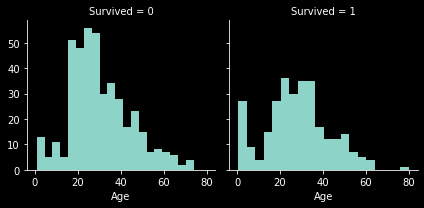

In [45]:
g = sns.FacetGrid(train, col="Survived")
g.map(plt.hist, 'Age', bins=20)

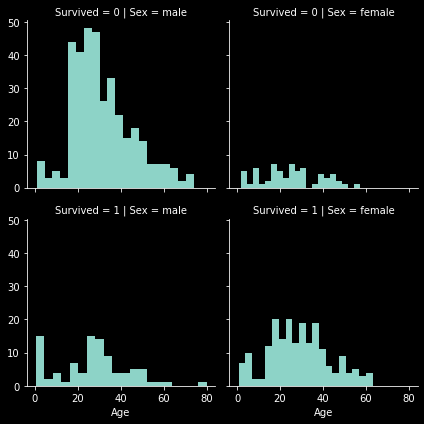

In [58]:
g = sns.FacetGrid(train, col="Sex", row="Survived")
g.map(plt.hist, 'Age', bins=20)

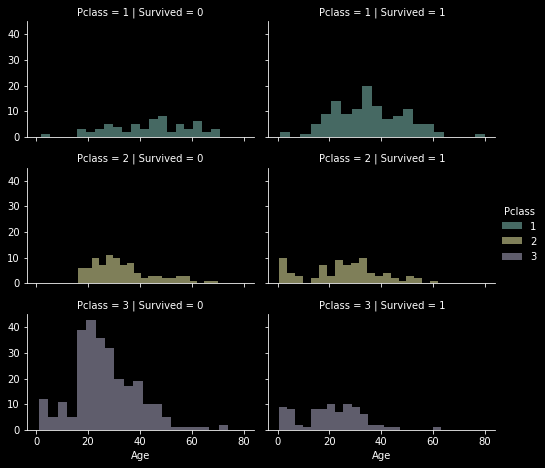

In [54]:
grid = sns.FacetGrid(train, col="Survived", row="Pclass",hue="Pclass",height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5,bins=20)
grid.add_legend();

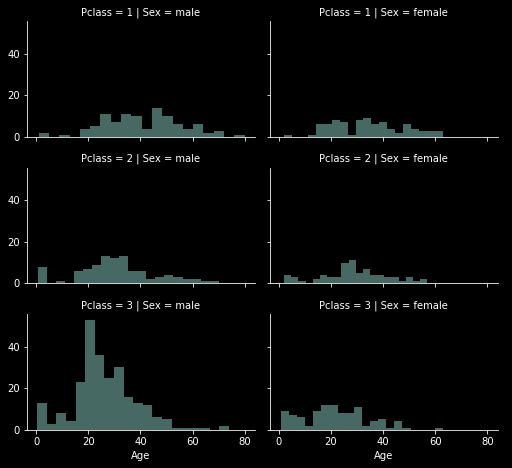

In [56]:
grid = sns.FacetGrid(train, row="Pclass", col="Sex", height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [5]:
print(train.columns)
print(train.shape)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 12)


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabin 칼럼의 경우 결측치의 비중이 너무 높으므로 남은 데이터로 추정하면 노이즈만 증가할 것으로 보이므로 제거

In [8]:
train_thresh = train.dropna(axis = 1, thresh = 2*len(train)/3)
train_thresh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [76]:
# df = train[train["Embarked"].isnull() | train["Age"].isnull() | train["Cabin"].isnull()]
# df

In [9]:
train_thresh.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

In [10]:
train_thresh["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
train_thresh = train_thresh[train_thresh["Embarked"].isnull()].fillna("S")

In [12]:
train_thresh[train_thresh["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16623061819474186562]

In [96]:
# data.replace("male", 0, inplace=True); data.replace("female",1,inplace=True)
train['Sex'] = train["Sex"].astype('category')
# print(train.head(2))
print(train.Sex.cat.categories)
print(train.Sex.cat.codes.head(5))

train["Sex"] = train.Sex.cat.codes
train["Sex"]

Int64Index([0, 1], dtype='int64')
0    1
1    0
2    0
3    0
4    1
dtype: int8


0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int8

In [28]:
sns.heatmap(data)

ValueError: could not convert string to float: 'Kelly, Mr. James'